In [1]:
import os
import numpy as np
import pandas as pd

from src.utils import sharpe
from src.utils import deco_print
from src.utils import load_dataframe
from src.utils import calculateTurnover_with_dl
from src.utils import construct_decile_portfolios
from src.utils import plot_decile_portfolios
from src.utils import plotReturnDecile
from src.utils import max_1_month_loss
from src.utils import max_drawdown
from src.data.data_layer import DataInRamInputLayer
from src.model.model_utils import calculateStatistics
from src.model.model_utils import getFactorWithLargeCap
from src.model.model_Linear import ModelLinear

##### Load Data

In [2]:
dl_train = DataInRamInputLayer('datasets/char_all_na_rm_all_50/TSplit/CharAll_na_rm_all_50_percent_train_shift.npz')
dl_valid = DataInRamInputLayer('datasets/char_all_na_rm_all_50/TSplit/CharAll_na_rm_all_50_percent_valid_shift.npz')
dl_test = DataInRamInputLayer('datasets/char_all_na_rm_all_50/TSplit/CharAll_na_rm_all_50_percent_test_shift.npz')

In [3]:
### Large Cap Stocks
tmp = np.load('datasets/char_all_na_rm_all_50/TSplit/mask_LME.npz')
mask_train = tmp['train']
mask_valid = tmp['valid']
mask_test = tmp['test']

In [4]:
### Large Cap Stocks 0.001%
tmp = np.load('datasets/char_all_na_rm_all_50/TSplit/mask_LME_0001.npz')
mask_train_0001 = tmp['train']
mask_valid_0001 = tmp['valid']
mask_test_0001 = tmp['test']

In [5]:
### Risk-free rate
df_tmp = load_dataframe('datasets/F-F_Research_Data_5_Factors_2x3.CSV', skiprows=2, nrows=659)
df_train = df_tmp.loc['196701':'198612']
df_valid = df_tmp.loc['198701':'199112']
df_test = df_tmp.loc['199201':'201612']
rf_train = df_train.loc[:,'RF'].values / 100
rf_valid = df_valid.loc[:,'RF'].values / 100
rf_test = df_test.loc[:,'RF'].values / 100

##### Load Model

In [6]:
model = ModelLinear(46, long_short=True, fit_intercept_beta=True)

### I. LS Model

In [7]:
# model.train(dl_train, 'model_char_shift/model_Linear_LS/LS', reg=False, fit_normalizedF=True)
model.loadSavedModel('model_char_shift/model_Linear_LS/LS')

>==================> Model Restored! 


##### Variable Importance

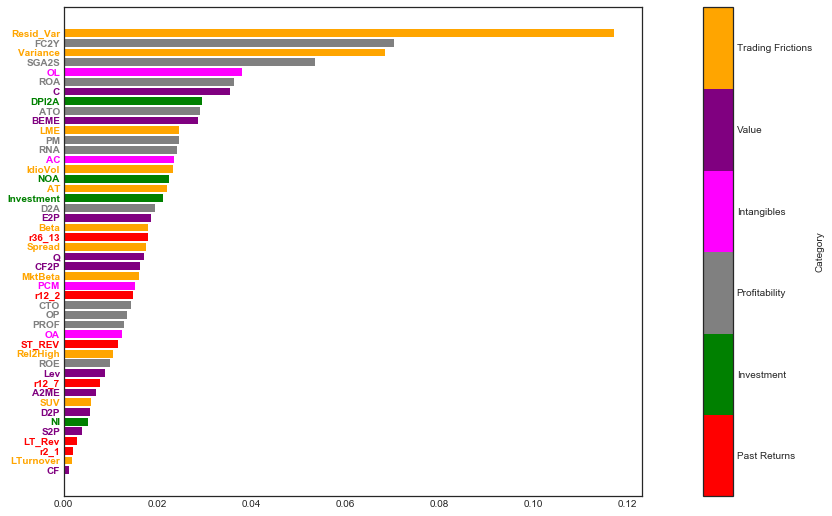

In [5]:
model.plotIndividualFeatureImportance(dl_test, plotPath='model_char_shift/model_Linear_LS/LS/plot', top=46, figsize=(12, 9))

##### Model Performance

In [8]:
Ftrain = model.getNormalizedSDFFactor(dl_train, norm='l1')
Fvalid = model.getNormalizedSDFFactor(dl_valid, norm='l1')
Ftest = model.getNormalizedSDFFactor(dl_test, norm='l1')
# np.savez('model_char_shift/model_Linear_LS/LS/SDF_normalized.npz', train=Ftrain, valid=Fvalid, test=Ftest)

In [9]:
SR_train = sharpe(Ftrain)
SR_valid = sharpe(Fvalid)
SR_test = sharpe(Ftest)
deco_print('SDF Portfolio Sharpe Ratio: Train %0.2f\tValid %0.2f\tTest %0.2f' %(SR_train, SR_valid, SR_test))
loss_train = max_1_month_loss(Ftrain / Ftrain.std())
loss_valid = max_1_month_loss(Fvalid / Fvalid.std())
loss_test = max_1_month_loss(Ftest / Ftest.std())
deco_print('Max 1 Month Loss: Train %0.2f\tValid %0.2f\tTest %0.2f' %(loss_train, loss_valid, loss_test))
drawdown_train = max_drawdown(Ftrain)
drawdown_valid = max_drawdown(Fvalid)
drawdown_test = max_drawdown(Ftest)
deco_print('Max Drawdown: Train %d\tValid %d\tTest %d' %(drawdown_train, drawdown_valid, drawdown_test))

>==================> SDF Portfolio Sharpe Ratio: Train 1.80	Valid 0.58	Test 0.42
>==================> Max 1 Month Loss: Train -1.96	Valid -1.87	Test -4.99
>==================> Max Drawdown: Train 1	Valid 3	Test 4


In [10]:
Ftrain = model.getSDFFactor(dl_train)
Fvalid = model.getSDFFactor(dl_valid)
Ftest = model.getSDFFactor(dl_test)
# np.savez('model_char_shift/model_Linear_LS/LS/SDF.npz', train=Ftrain, valid=Fvalid, test=Ftest)

In [11]:
SR_train = sharpe(Ftrain)
SR_valid = sharpe(Fvalid)
SR_test = sharpe(Ftest)
deco_print('SDF Portfolio Sharpe Ratio: Train %0.2f\tValid %0.2f\tTest %0.2f' %(SR_train, SR_valid, SR_test))
loss_train = max_1_month_loss(Ftrain / Ftrain.std())
loss_valid = max_1_month_loss(Fvalid / Fvalid.std())
loss_test = max_1_month_loss(Ftest / Ftest.std())
deco_print('Max 1 Month Loss: Train %0.2f\tValid %0.2f\tTest %0.2f' %(loss_train, loss_valid, loss_test))
drawdown_train = max_drawdown(Ftrain)
drawdown_valid = max_drawdown(Fvalid)
drawdown_test = max_drawdown(Ftest)
deco_print('Max Drawdown: Train %d\tValid %d\tTest %d' %(drawdown_train, drawdown_valid, drawdown_test))

>==================> SDF Portfolio Sharpe Ratio: Train 1.82	Valid 0.57	Test 0.41
>==================> Max 1 Month Loss: Train -1.54	Valid -1.96	Test -5.13
>==================> Max Drawdown: Train 1	Valid 3	Test 4


In [6]:
w_train = model.getWeightWithData(dl_train)
w_valid = model.getWeightWithData(dl_valid)
w_test = model.getWeightWithData(dl_test)

In [13]:
### Large Cap
Ftrain = getFactorWithLargeCap(w_train, dl_train, mask_train, normalized=True, norm='l1')
Fvalid = getFactorWithLargeCap(w_valid, dl_valid, mask_valid, normalized=True, norm='l1')
Ftest = getFactorWithLargeCap(w_test, dl_test, mask_test, normalized=True, norm='l1')

In [14]:
SR_train = sharpe(Ftrain)
SR_valid = sharpe(Fvalid)
SR_test = sharpe(Ftest)
deco_print('SDF Portfolio Sharpe Ratio: Train %0.2f\tValid %0.2f\tTest %0.2f' %(SR_train, SR_valid, SR_test))
loss_train = max_1_month_loss(Ftrain / Ftrain.std())
loss_valid = max_1_month_loss(Fvalid / Fvalid.std())
loss_test = max_1_month_loss(Ftest / Ftest.std())
deco_print('Max 1 Month Loss: Train %0.2f\tValid %0.2f\tTest %0.2f' %(loss_train, loss_valid, loss_test))
drawdown_train = max_drawdown(Ftrain)
drawdown_valid = max_drawdown(Fvalid)
drawdown_test = max_drawdown(Ftest)
deco_print('Max Drawdown: Train %d\tValid %d\tTest %d' %(drawdown_train, drawdown_valid, drawdown_test))

>==================> SDF Portfolio Sharpe Ratio: Train 0.32	Valid -0.11	Test -0.06
>==================> Max 1 Month Loss: Train -3.11	Valid -1.82	Test -3.67
>==================> Max Drawdown: Train 4	Valid 5	Test 7


In [7]:
### Large Cap 0.001%
Ftrain = getFactorWithLargeCap(w_train, dl_train, mask_train_0001, normalized=True, norm='l1')
Fvalid = getFactorWithLargeCap(w_valid, dl_valid, mask_valid_0001, normalized=True, norm='l1')
Ftest = getFactorWithLargeCap(w_test, dl_test, mask_test_0001, normalized=True, norm='l1')

In [8]:
SR_train = sharpe(Ftrain)
SR_valid = sharpe(Fvalid)
SR_test = sharpe(Ftest)
deco_print('SDF Portfolio Sharpe Ratio: Train %0.2f\tValid %0.2f\tTest %0.2f' %(SR_train, SR_valid, SR_test))
loss_train = max_1_month_loss(Ftrain / Ftrain.std())
loss_valid = max_1_month_loss(Fvalid / Fvalid.std())
loss_test = max_1_month_loss(Ftest / Ftest.std())
deco_print('Max 1 Month Loss: Train %0.2f\tValid %0.2f\tTest %0.2f' %(loss_train, loss_valid, loss_test))
drawdown_train = max_drawdown(Ftrain)
drawdown_valid = max_drawdown(Fvalid)
drawdown_test = max_drawdown(Ftest)
deco_print('Max Drawdown: Train %d\tValid %d\tTest %d' %(drawdown_train, drawdown_valid, drawdown_test))

>==================> SDF Portfolio Sharpe Ratio: Train 1.44	Valid 0.31	Test 0.13
>==================> Max 1 Month Loss: Train -3.07	Valid -2.19	Test -4.59
>==================> Max Drawdown: Train 1	Valid 3	Test 7


In [15]:
### EV, XS-R2
EV_train, XSR2_train, WXSR2_train = model.calculateStatistics(dl_train)
EV_valid, XSR2_valid, WXSR2_valid = model.calculateStatistics(dl_valid)
EV_test, XSR2_test, WXSR2_test = model.calculateStatistics(dl_test)

In [16]:
deco_print('Explained Variation: Train %0.2f\tValid %0.2f\tTest %0.2f' %(EV_train, EV_valid, EV_test))
deco_print('XS-R2: Train %0.2f\tValid %0.2f\tTest %0.2f' %(XSR2_train, XSR2_valid, XSR2_test))
deco_print('(Weighted) XS-R2: Train %0.2f\tValid %0.2f\tTest %0.2f' %(WXSR2_train, WXSR2_valid, WXSR2_test))

>==================> Explained Variation: Train 0.09	Valid 0.03	Test 0.03
>==================> XS-R2: Train 0.03	Valid 0.03	Test 0.02
>==================> (Weighted) XS-R2: Train 0.15	Valid 0.00	Test 0.14


In [7]:
### Large Cap
beta_train = model.getBetaWithData(dl_train)
beta_valid = model.getBetaWithData(dl_valid)
beta_test = model.getBetaWithData(dl_test)
EV_train, XSR2_train, WXSR2_train = calculateStatistics(beta_train, dl_train, mask_train)
EV_valid, XSR2_valid, WXSR2_valid = calculateStatistics(beta_valid, dl_valid, mask_valid)
EV_test, XSR2_test, WXSR2_test = calculateStatistics(beta_test, dl_test, mask_test)

In [8]:
deco_print('Explained Variation: Train %0.2f\tValid %0.2f\tTest %0.2f' %(EV_train, EV_valid, EV_test))
deco_print('XS-R2: Train %0.2f\tValid %0.2f\tTest %0.2f' %(XSR2_train, XSR2_valid, XSR2_test))
deco_print('(Weighted) XS-R2: Train %0.2f\tValid %0.2f\tTest %0.2f' %(WXSR2_train, WXSR2_valid, WXSR2_test))

>==================> Explained Variation: Train 0.05	Valid 0.07	Test 0.04
>==================> XS-R2: Train 0.01	Valid -0.06	Test 0.03
>==================> (Weighted) XS-R2: Train 0.13	Valid 0.05	Test 0.09


In [9]:
### Large Cap 0.001%
beta_train = model.getBetaWithData(dl_train)
beta_valid = model.getBetaWithData(dl_valid)
beta_test = model.getBetaWithData(dl_test)
EV_train, XSR2_train, WXSR2_train = calculateStatistics(beta_train, dl_train, mask_train_0001)
EV_valid, XSR2_valid, WXSR2_valid = calculateStatistics(beta_valid, dl_valid, mask_valid_0001)
EV_test, XSR2_test, WXSR2_test = calculateStatistics(beta_test, dl_test, mask_test_0001)

In [10]:
deco_print('Explained Variation: Train %0.2f\tValid %0.2f\tTest %0.2f' %(EV_train, EV_valid, EV_test))
deco_print('XS-R2: Train %0.2f\tValid %0.2f\tTest %0.2f' %(XSR2_train, XSR2_valid, XSR2_test))
deco_print('(Weighted) XS-R2: Train %0.2f\tValid %0.2f\tTest %0.2f' %(WXSR2_train, WXSR2_valid, WXSR2_test))

>==================> Explained Variation: Train 0.07	Valid 0.05	Test 0.03
>==================> XS-R2: Train 0.02	Valid 0.05	Test -0.00
>==================> (Weighted) XS-R2: Train 0.14	Valid 0.03	Test 0.10


In [8]:
### Turnover
w_train = model.getNormalizedWeightWithData(dl_train)
w_valid = model.getNormalizedWeightWithData(dl_valid)
w_test = model.getNormalizedWeightWithData(dl_test)

_, _, T_train_plus_mean, T_train_minus_mean = calculateTurnover_with_dl(dl_train, w_train, rf_train)
_, _, T_valid_plus_mean, T_valid_minus_mean = calculateTurnover_with_dl(dl_valid, w_valid, rf_valid)
_, _, T_test_plus_mean, T_test_minus_mean = calculateTurnover_with_dl(dl_test, w_test, rf_test)

In [9]:
deco_print('Turnover (Long): Train %0.2f\tValid %0.2f\tTest %0.2f' %(T_train_plus_mean, T_valid_plus_mean, T_test_plus_mean))
deco_print('Turnover (Short): Train %0.2f\tValid %0.2f\tTest %0.2f' %(T_train_minus_mean, T_valid_minus_mean, T_test_minus_mean))

>==================> Turnover (Long): Train 0.25	Valid 0.22	Test 0.24
>==================> Turnover (Short): Train 0.64	Valid 0.55	Test 0.61


##### Predictive Performance

In [9]:
decile = 10
for _, (I_macro, I, R, mask) in enumerate(dl_train.iterateOneEpoch(subEpoch=False)):
    portfolios_train = construct_decile_portfolios(beta_train, R, mask, decile=decile)
for _, (I_macro, I, R, mask) in enumerate(dl_valid.iterateOneEpoch(subEpoch=False)):
    portfolios_valid = construct_decile_portfolios(beta_valid, R, mask, decile=decile)
for _, (I_macro, I, R, mask) in enumerate(dl_test.iterateOneEpoch(subEpoch=False)):
    portfolios_test = construct_decile_portfolios(beta_test, R, mask, decile=decile)
df = pd.DataFrame(np.concatenate([portfolios_train, portfolios_valid, portfolios_test]), columns=['decile %d' %(k+1) for k in range(decile)])

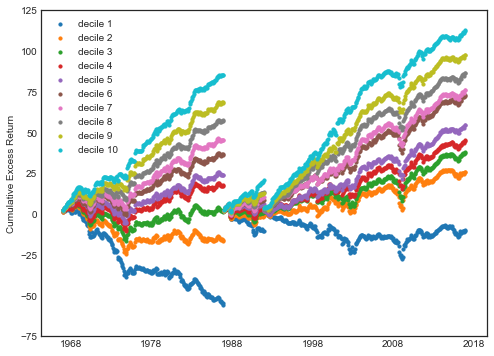

In [9]:
plot_decile_portfolios(df, plotPath='model_char_shift/model_Linear_LS/LS/plot') # beta

>==================> Plotting Variable: ST_REV	Elapse / Estimate: 1.36s / 1.36s


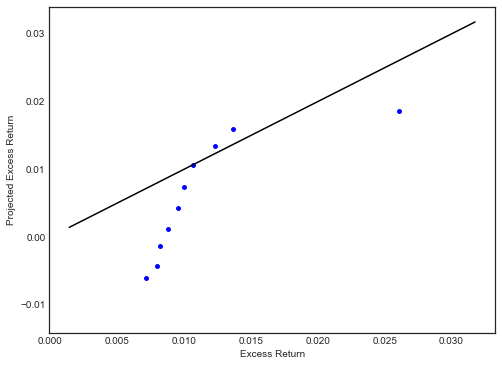

In [11]:
plotReturnDecile(dl_test, beta_test, 'ST_REV')

>==================> Plotting Variable: A2ME	Elapse / Estimate: 1.35s / 61.93s
>==================> Plotting Variable: AC	Elapse / Estimate: 2.76s / 63.39s
>==================> Plotting Variable: AT	Elapse / Estimate: 4.27s / 65.52s
>==================> Plotting Variable: ATO	Elapse / Estimate: 5.60s / 64.46s
>==================> Plotting Variable: BEME	Elapse / Estimate: 6.90s / 63.46s
>==================> Plotting Variable: Beta	Elapse / Estimate: 8.26s / 63.34s
>==================> Plotting Variable: C	Elapse / Estimate: 9.70s / 63.73s
>==================> Plotting Variable: CF	Elapse / Estimate: 11.08s / 63.69s
>==================> Plotting Variable: CF2P	Elapse / Estimate: 12.38s / 63.25s
>==================> Plotting Variable: CTO	Elapse / Estimate: 13.70s / 63.03s
>==================> Plotting Variable: D2A	Elapse / Estimate: 15.00s / 62.74s
>==================> Plotting Variable: D2P	Elapse / Estimate: 16.24s / 62.24s
>==================> Plotting Variable: DPI2A	Elapse / Estim

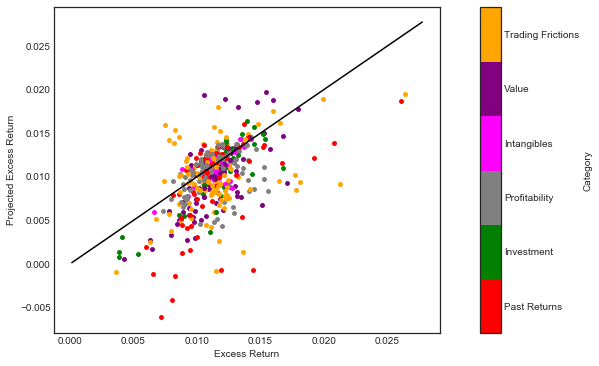

In [12]:
plotReturnDecile(dl_test, beta_test, plotPath='model_char_shift/model_Linear_LS/LS/plot')

##### Plot Weight As Function of Firm Characteristics

>==================> Plotting Variable: ST_REV	Elapse / Estimate: 0.00s / 0.00s


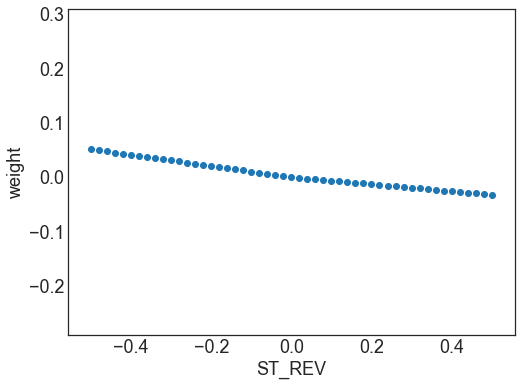

In [7]:
model.plotWeightOrBeta1DWithChar(dl_test, plotBeta=False, charName='ST_REV')

>==================> Please enter the idx for the plot you want! 
Please select from 1.1D, 2.2D Contour 3.2D Contour Slice 4. 1D Curves: 4
Enter variable idx for x (0 - 45): 32
Enter variable idx for y (0 - 45): 43


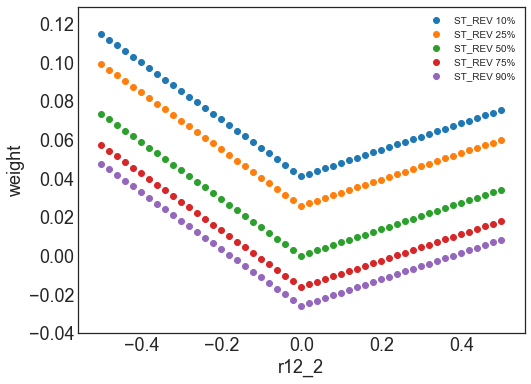

In [8]:
model.plotWeightOrBeta(dl_test, plotBeta=False, plotPath='model_char_shift/model_Linear_LS/LS/plot/2D')

>==================> Please enter the idx for the plot you want! 
Please select from 1.1D, 2.2D Contour 3.2D Contour Slice 4.1D Curves (2 Variables) 5.1D Curves (3 Variables): 5
Enter variable idx for x (0 - 45): 43
Enter variable idx for y (0 - 45): 18
Enter variable idx for z (0 - 45): 4


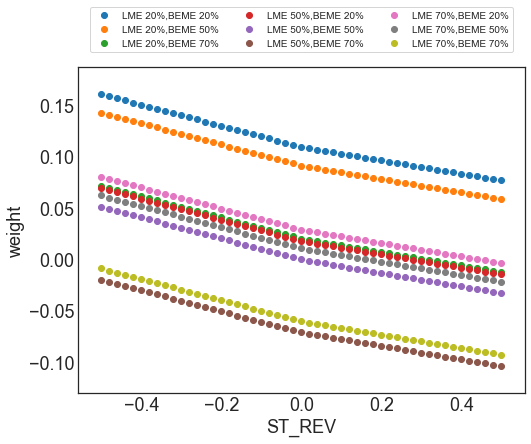

In [12]:
model.plotWeightOrBeta(dl_test, plotBeta=False, plotPath='model_char_shift/model_Linear_LS/LS/plot/3D')

In [18]:
# model.plotWeightOrBeta1DWithChar(dl_test, plotBeta=False, charName='All', plotPath='model_char_shift/model_Linear_LS/LS/plot/1D')

>==================> Please enter the idx for the plot you want! 
Please select from 1.1D, 2.2D Contour 3.2D Contour Slice: 2
Enter variable idx for x (0 - 45): 43
Enter variable idx for y (0 - 45): 32


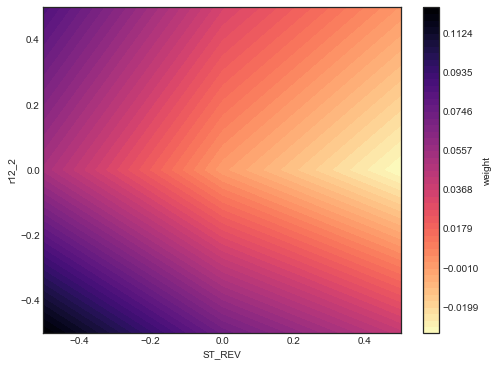

In [10]:
model.plotWeightOrBeta(dl_test, plotBeta=False, plotPath='model_char_shift/model_Linear_LS/LS/plot/2D')

>==================> Please enter the idx for the plot you want! 
Please select from 1.1D, 2.2D Contour 3.2D Contour Slice: 3
Enter variable idx for x (0 - 45): 43
Enter variable idx for y (0 - 45): 32
Enter variable idx for z (0 - 45): 44


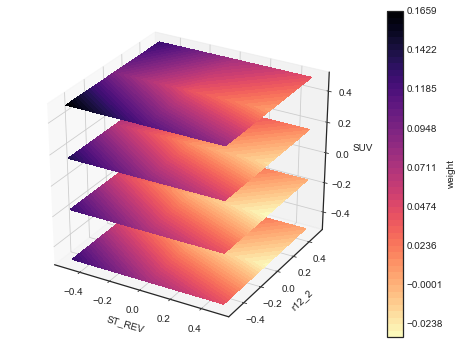

In [12]:
model.plotWeightOrBeta(dl_test, plotBeta=False, plotPath='model_char_shift/model_Linear_LS/LS/plot/3D')

##### Plot Beta As Function of Firm Characteristics

>==================> Please enter the idx for the plot you want! 
Please select from 1.1D, 2.2D Contour 3.2D Contour Slice 4.1D Curves (2 Variables) 5.1D Curves (3 Variables): 1
Enter variable idx for x (0 - 45): 20


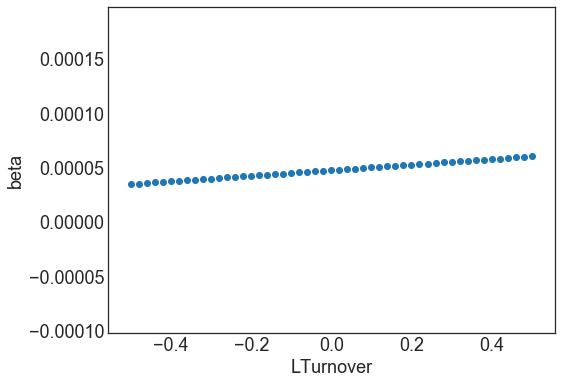

In [16]:
model.plotWeightOrBeta(dl_test, plotBeta=True, plotPath='model_char_shift/model_Linear_LS/LS/plot/beta')

### II. Lasso Model

In [10]:
# model.train(dl_train, 'model_char_shift/model_Linear_LS/ElasticNet', reg=True, fit_normalizedF=True)
model.loadSavedModel('model_char_shift/model_Linear_LS/ElasticNet')

>==================> Model Restored! 


##### Variable Importance

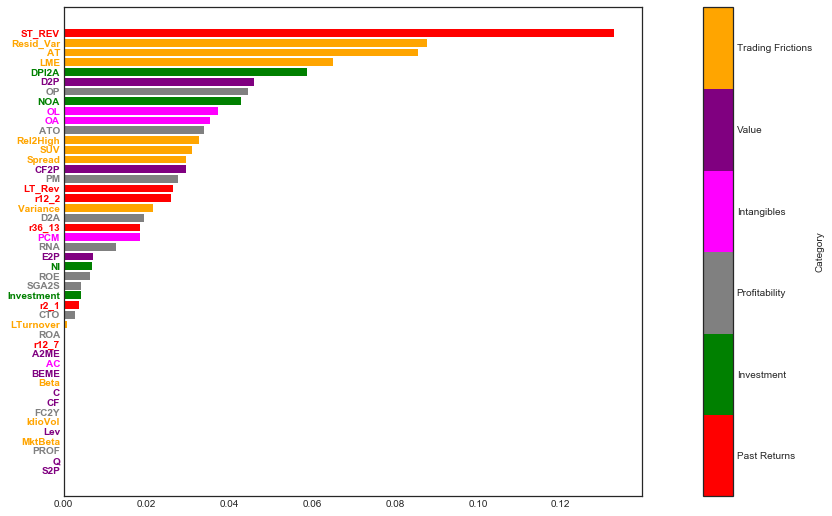

In [7]:
model.plotIndividualFeatureImportance(dl_test, plotPath='model_char_shift/model_Linear_LS/ElasticNet/plot', top=46, figsize=(12, 9))

##### Model Performance

In [11]:
Ftrain = model.getNormalizedSDFFactor(dl_train, norm='l1')
Fvalid = model.getNormalizedSDFFactor(dl_valid, norm='l1')
Ftest = model.getNormalizedSDFFactor(dl_test, norm='l1')
# np.savez('model_char_shift/model_Linear_LS/ElasticNet/SDF_normalized.npz', train=Ftrain, valid=Fvalid, test=Ftest)

In [12]:
SR_train = sharpe(Ftrain)
SR_valid = sharpe(Fvalid)
SR_test = sharpe(Ftest)
deco_print('SDF Portfolio Sharpe Ratio: Train %0.2f\tValid %0.2f\tTest %0.2f' %(SR_train, SR_valid, SR_test))
loss_train = max_1_month_loss(Ftrain / Ftrain.std())
loss_valid = max_1_month_loss(Fvalid / Fvalid.std())
loss_test = max_1_month_loss(Ftest / Ftest.std())
deco_print('Max 1 Month Loss: Train %0.2f\tValid %0.2f\tTest %0.2f' %(loss_train, loss_valid, loss_test))
drawdown_train = max_drawdown(Ftrain)
drawdown_valid = max_drawdown(Fvalid)
drawdown_test = max_drawdown(Ftest)
deco_print('Max Drawdown: Train %d\tValid %d\tTest %d' %(drawdown_train, drawdown_valid, drawdown_test))

>==================> SDF Portfolio Sharpe Ratio: Train 1.37	Valid 1.15	Test 0.50
>==================> Max 1 Month Loss: Train -2.22	Valid -1.81	Test -6.18
>==================> Max Drawdown: Train 1	Valid 3	Test 5


In [8]:
Ftrain = model.getSDFFactor(dl_train)
Fvalid = model.getSDFFactor(dl_valid)
Ftest = model.getSDFFactor(dl_test)
# np.savez('model_char_shift/model_Linear_LS/ElasticNet/SDF.npz', train=Ftrain, valid=Fvalid, test=Ftest)

In [9]:
SR_train = sharpe(Ftrain)
SR_valid = sharpe(Fvalid)
SR_test = sharpe(Ftest)
deco_print('SDF Portfolio Sharpe Ratio: Train %0.2f\tValid %0.2f\tTest %0.2f' %(SR_train, SR_valid, SR_test))
loss_train = max_1_month_loss(Ftrain / Ftrain.std())
loss_valid = max_1_month_loss(Fvalid / Fvalid.std())
loss_test = max_1_month_loss(Ftest / Ftest.std())
deco_print('Max 1 Month Loss: Train %0.2f\tValid %0.2f\tTest %0.2f' %(loss_train, loss_valid, loss_test))
drawdown_train = max_drawdown(Ftrain)
drawdown_valid = max_drawdown(Fvalid)
drawdown_test = max_drawdown(Ftest)
deco_print('Max Drawdown: Train %d\tValid %d\tTest %d' %(drawdown_train, drawdown_valid, drawdown_test))

>==================> SDF Portfolio Sharpe Ratio: Train 1.28	Valid 1.13	Test 0.47
>==================> Max 1 Month Loss: Train -2.20	Valid -1.82	Test -5.77
>==================> Max Drawdown: Train 1	Valid 3	Test 5


In [12]:
w_train = model.getWeightWithData(dl_train)
w_valid = model.getWeightWithData(dl_valid)
w_test = model.getWeightWithData(dl_test)

In [11]:
### Large Cap
Ftrain = getFactorWithLargeCap(w_train, dl_train, mask_train, normalized=True, norm='l1')
Fvalid = getFactorWithLargeCap(w_valid, dl_valid, mask_valid, normalized=True, norm='l1')
Ftest = getFactorWithLargeCap(w_test, dl_test, mask_test, normalized=True, norm='l1')

In [12]:
SR_train = sharpe(Ftrain)
SR_valid = sharpe(Fvalid)
SR_test = sharpe(Ftest)
deco_print('SDF Portfolio Sharpe Ratio: Train %0.2f\tValid %0.2f\tTest %0.2f' %(SR_train, SR_valid, SR_test))
loss_train = max_1_month_loss(Ftrain / Ftrain.std())
loss_valid = max_1_month_loss(Fvalid / Fvalid.std())
loss_test = max_1_month_loss(Ftest / Ftest.std())
deco_print('Max 1 Month Loss: Train %0.2f\tValid %0.2f\tTest %0.2f' %(loss_train, loss_valid, loss_test))
drawdown_train = max_drawdown(Ftrain)
drawdown_valid = max_drawdown(Fvalid)
drawdown_test = max_drawdown(Ftest)
deco_print('Max Drawdown: Train %d\tValid %d\tTest %d' %(drawdown_train, drawdown_valid, drawdown_test))

>==================> SDF Portfolio Sharpe Ratio: Train 0.37	Valid 0.26	Test 0.23
>==================> Max 1 Month Loss: Train -4.44	Valid -2.67	Test -4.66
>==================> Max Drawdown: Train 4	Valid 3	Test 7


In [13]:
### Large Cap 0.001%
Ftrain = getFactorWithLargeCap(w_train, dl_train, mask_train_0001, normalized=True, norm='l1')
Fvalid = getFactorWithLargeCap(w_valid, dl_valid, mask_valid_0001, normalized=True, norm='l1')
Ftest = getFactorWithLargeCap(w_test, dl_test, mask_test_0001, normalized=True, norm='l1')

In [14]:
SR_train = sharpe(Ftrain)
SR_valid = sharpe(Fvalid)
SR_test = sharpe(Ftest)
deco_print('SDF Portfolio Sharpe Ratio: Train %0.2f\tValid %0.2f\tTest %0.2f' %(SR_train, SR_valid, SR_test))
loss_train = max_1_month_loss(Ftrain / Ftrain.std())
loss_valid = max_1_month_loss(Fvalid / Fvalid.std())
loss_test = max_1_month_loss(Ftest / Ftest.std())
deco_print('Max 1 Month Loss: Train %0.2f\tValid %0.2f\tTest %0.2f' %(loss_train, loss_valid, loss_test))
drawdown_train = max_drawdown(Ftrain)
drawdown_valid = max_drawdown(Fvalid)
drawdown_test = max_drawdown(Ftest)
deco_print('Max Drawdown: Train %d\tValid %d\tTest %d' %(drawdown_train, drawdown_valid, drawdown_test))

>==================> SDF Portfolio Sharpe Ratio: Train 0.93	Valid 0.56	Test 0.15
>==================> Max 1 Month Loss: Train -3.00	Valid -2.45	Test -4.82
>==================> Max Drawdown: Train 2	Valid 3	Test 5


In [13]:
### EV, XS-R2
EV_train, XSR2_train, WXSR2_train = model.calculateStatistics(dl_train)
EV_valid, XSR2_valid, WXSR2_valid = model.calculateStatistics(dl_valid)
EV_test, XSR2_test, WXSR2_test = model.calculateStatistics(dl_test)

In [14]:
deco_print('Explained Variation: Train %0.2f\tValid %0.2f\tTest %0.2f' %(EV_train, EV_valid, EV_test))
deco_print('XS-R2: Train %0.2f\tValid %0.2f\tTest %0.2f' %(XSR2_train, XSR2_valid, XSR2_test))
deco_print('(Weighted) XS-R2: Train %0.2f\tValid %0.2f\tTest %0.2f' %(WXSR2_train, WXSR2_valid, WXSR2_test))

>==================> Explained Variation: Train 0.12	Valid 0.05	Test 0.04
>==================> XS-R2: Train 0.03	Valid 0.06	Test 0.03
>==================> (Weighted) XS-R2: Train 0.17	Valid 0.02	Test 0.19


In [8]:
### Large Cap
beta_train = model.getBetaWithData(dl_train)
beta_valid = model.getBetaWithData(dl_valid)
beta_test = model.getBetaWithData(dl_test)
# np.savez('model_char_shift/model_Linear_LS/ElasticNet/forecasts.npz', train=beta_train, valid=beta_valid, test=beta_test)
EV_train, XSR2_train, WXSR2_train = calculateStatistics(beta_train, dl_train, mask_train)
EV_valid, XSR2_valid, WXSR2_valid = calculateStatistics(beta_valid, dl_valid, mask_valid)
EV_test, XSR2_test, WXSR2_test = calculateStatistics(beta_test, dl_test, mask_test)

In [15]:
deco_print('Explained Variation: Train %0.2f\tValid %0.2f\tTest %0.2f' %(EV_train, EV_valid, EV_test))
deco_print('XS-R2: Train %0.2f\tValid %0.2f\tTest %0.2f' %(XSR2_train, XSR2_valid, XSR2_test))
deco_print('(Weighted) XS-R2: Train %0.2f\tValid %0.2f\tTest %0.2f' %(WXSR2_train, WXSR2_valid, WXSR2_test))

>==================> Explained Variation: Train 0.09	Valid 0.12	Test 0.07
>==================> XS-R2: Train -0.01	Valid -0.04	Test 0.01
>==================> (Weighted) XS-R2: Train 0.17	Valid 0.08	Test 0.14


In [15]:
### Large Cap 0.001%
beta_train = model.getBetaWithData(dl_train)
beta_valid = model.getBetaWithData(dl_valid)
beta_test = model.getBetaWithData(dl_test)
EV_train, XSR2_train, WXSR2_train = calculateStatistics(beta_train, dl_train, mask_train_0001)
EV_valid, XSR2_valid, WXSR2_valid = calculateStatistics(beta_valid, dl_valid, mask_valid_0001)
EV_test, XSR2_test, WXSR2_test = calculateStatistics(beta_test, dl_test, mask_test_0001)

In [16]:
deco_print('Explained Variation: Train %0.2f\tValid %0.2f\tTest %0.2f' %(EV_train, EV_valid, EV_test))
deco_print('XS-R2: Train %0.2f\tValid %0.2f\tTest %0.2f' %(XSR2_train, XSR2_valid, XSR2_test))
deco_print('(Weighted) XS-R2: Train %0.2f\tValid %0.2f\tTest %0.2f' %(WXSR2_train, WXSR2_valid, WXSR2_test))

>==================> Explained Variation: Train 0.11	Valid 0.09	Test 0.06
>==================> XS-R2: Train 0.03	Valid 0.07	Test -0.00
>==================> (Weighted) XS-R2: Train 0.17	Valid 0.05	Test 0.14


In [13]:
### Turnover
w_train = model.getNormalizedWeightWithData(dl_train)
w_valid = model.getNormalizedWeightWithData(dl_valid)
w_test = model.getNormalizedWeightWithData(dl_test)

_, _, T_train_plus_mean, T_train_minus_mean = calculateTurnover_with_dl(dl_train, w_train, rf_train)
_, _, T_valid_plus_mean, T_valid_minus_mean = calculateTurnover_with_dl(dl_valid, w_valid, rf_valid)
_, _, T_test_plus_mean, T_test_minus_mean = calculateTurnover_with_dl(dl_test, w_test, rf_test)

In [14]:
deco_print('Turnover (Long): Train %0.2f\tValid %0.2f\tTest %0.2f' %(T_train_plus_mean, T_valid_plus_mean, T_test_plus_mean))
deco_print('Turnover (Short): Train %0.2f\tValid %0.2f\tTest %0.2f' %(T_train_minus_mean, T_valid_minus_mean, T_test_minus_mean))

>==================> Turnover (Long): Train 0.36	Valid 0.35	Test 0.35
>==================> Turnover (Short): Train 0.83	Valid 0.83	Test 0.84


##### Predictive Performance

In [13]:
decile = 10
for _, (I_macro, I, R, mask) in enumerate(dl_train.iterateOneEpoch(subEpoch=False)):
    portfolios_train = construct_decile_portfolios(beta_train, R, mask, decile=decile)
for _, (I_macro, I, R, mask) in enumerate(dl_valid.iterateOneEpoch(subEpoch=False)):
    portfolios_valid = construct_decile_portfolios(beta_valid, R, mask, decile=decile)
for _, (I_macro, I, R, mask) in enumerate(dl_test.iterateOneEpoch(subEpoch=False)):
    portfolios_test = construct_decile_portfolios(beta_test, R, mask, decile=decile)
df = pd.DataFrame(np.concatenate([portfolios_train, portfolios_valid, portfolios_test]), columns=['decile %d' %(k+1) for k in range(decile)])

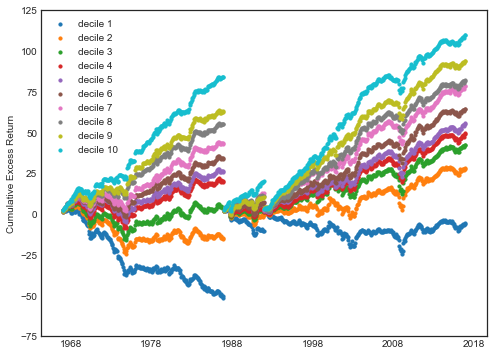

In [14]:
plot_decile_portfolios(df, plotPath='model_char_shift/model_Linear_LS/ElasticNet/plot') # beta

>==================> Plotting Variable: r12_7	Elapse / Estimate: 1.48s / 1.48s


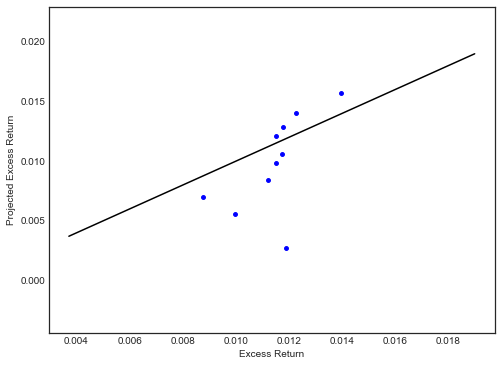

In [9]:
plotReturnDecile(dl_test, beta_test, 'r12_7')

>==================> Plotting Variable: A2ME	Elapse / Estimate: 1.36s / 62.56s
>==================> Plotting Variable: AC	Elapse / Estimate: 2.80s / 64.43s
>==================> Plotting Variable: AT	Elapse / Estimate: 4.19s / 64.31s
>==================> Plotting Variable: ATO	Elapse / Estimate: 5.70s / 65.56s
>==================> Plotting Variable: BEME	Elapse / Estimate: 6.99s / 64.35s
>==================> Plotting Variable: Beta	Elapse / Estimate: 8.29s / 63.56s
>==================> Plotting Variable: C	Elapse / Estimate: 9.63s / 63.28s
>==================> Plotting Variable: CF	Elapse / Estimate: 10.98s / 63.11s
>==================> Plotting Variable: CF2P	Elapse / Estimate: 12.37s / 63.24s
>==================> Plotting Variable: CTO	Elapse / Estimate: 13.69s / 63.00s
>==================> Plotting Variable: D2A	Elapse / Estimate: 15.04s / 62.91s
>==================> Plotting Variable: D2P	Elapse / Estimate: 16.32s / 62.56s
>==================> Plotting Variable: DPI2A	Elapse / Estim

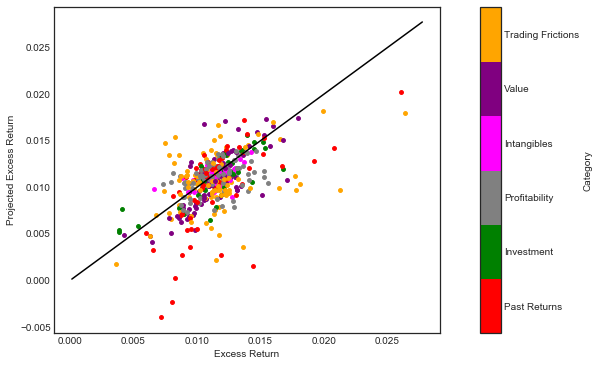

In [17]:
plotReturnDecile(dl_test, beta_test, plotPath='model_char_shift/model_Linear_LS/ElasticNet/plot')

##### Plot Weight As Function of Firm Characteristics

>==================> Plotting Variable: ST_REV	Elapse / Estimate: 0.00s / 0.00s


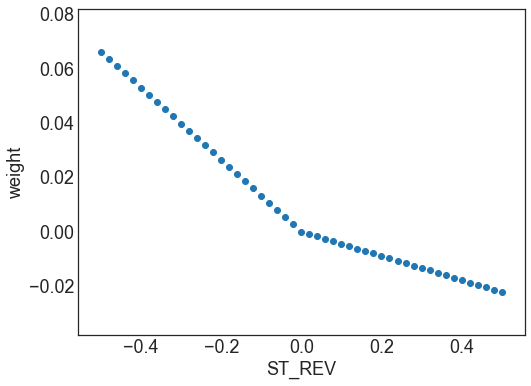

In [7]:
model.plotWeightOrBeta1DWithChar(dl_test, plotBeta=False, charName='ST_REV')

>==================> Please enter the idx for the plot you want! 
Please select from 1.1D, 2.2D Contour 3.2D Contour Slice 4. 1D Curves: 4
Enter variable idx for x (0 - 45): 32
Enter variable idx for y (0 - 45): 43


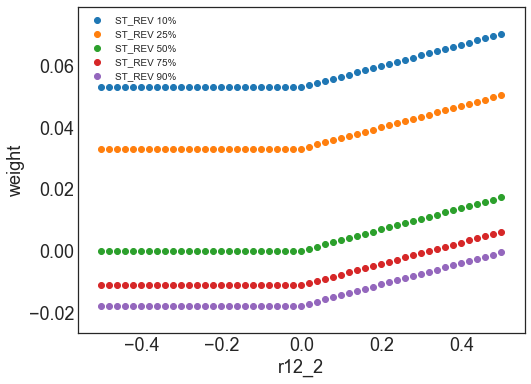

In [13]:
model.plotWeightOrBeta(dl_test, plotBeta=False, plotPath='model_char_shift/model_Linear_LS/ElasticNet/plot/2D')

>==================> Please enter the idx for the plot you want! 
Please select from 1.1D, 2.2D Contour 3.2D Contour Slice 4.1D Curves (2 Variables) 5.1D Curves (3 Variables): 5
Enter variable idx for x (0 - 45): 43
Enter variable idx for y (0 - 45): 18
Enter variable idx for z (0 - 45): 4


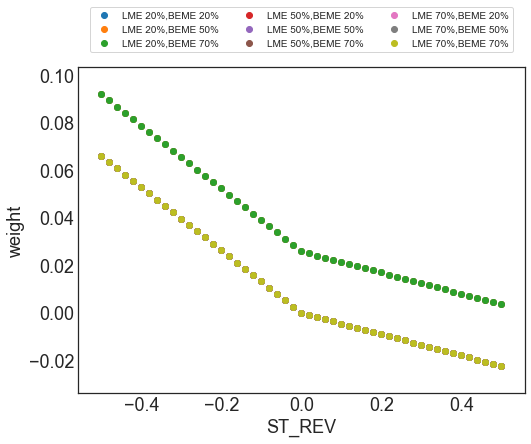

In [23]:
model.plotWeightOrBeta(dl_test, plotBeta=False, plotPath='model_char_shift/model_Linear_LS/ElasticNet/plot/3D')

In [17]:
# model.plotWeightOrBeta1DWithChar(dl_test, plotBeta=False, charName='All', plotPath='model_char_shift/model_Linear_LS/ElasticNet/plot/1D')

>==================> Please enter the idx for the plot you want! 
Please select from 1.1D, 2.2D Contour 3.2D Contour Slice: 2
Enter variable idx for x (0 - 45): 18
Enter variable idx for y (0 - 45): 4


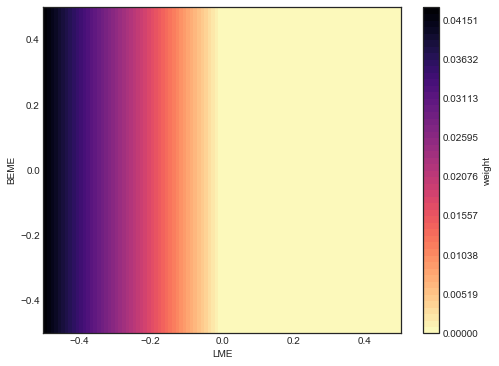

In [17]:
model.plotWeightOrBeta(dl_test, plotBeta=False, plotPath='model_char_shift/model_Linear_LS/ElasticNet/plot/2D')

>==================> Please enter the idx for the plot you want! 
Please select from 1.1D, 2.2D Contour 3.2D Contour Slice: 3
Enter variable idx for x (0 - 45): 43
Enter variable idx for y (0 - 45): 32
Enter variable idx for z (0 - 45): 44


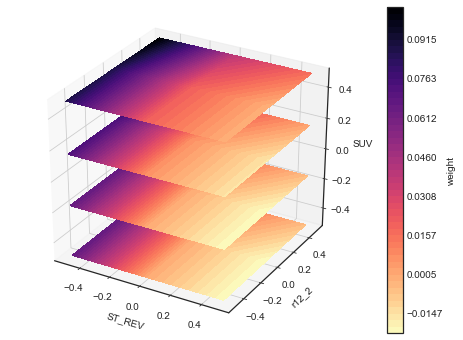

In [19]:
model.plotWeightOrBeta(dl_test, plotBeta=False, plotPath='model_char_shift/model_Linear_LS/ElasticNet/plot/3D')

##### Plot Beta As Function of Firm Characteristics

>==================> Please enter the idx for the plot you want! 
Please select from 1.1D, 2.2D Contour 3.2D Contour Slice 4.1D Curves (2 Variables) 5.1D Curves (3 Variables): 1
Enter variable idx for x (0 - 45): 20


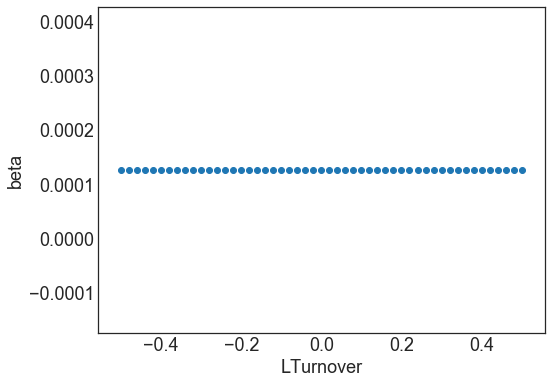

In [12]:
model.plotWeightOrBeta(dl_test, plotBeta=True, plotPath='model_char_shift/model_Linear_LS/ElasticNet/plot/beta')